# Python imports

In [1]:
import csv, time
import numpy as np
import multihash as mh
import hashlib as hl
import matplotlib.pyplot as plt
from binary_trie import Trie, bytes_to_bitstring, int_to_bitstring, bitstring_to_int

# Plot design

In [2]:
plt.rc('font', size=20)

# Helper functions and classes

In [3]:
def multihash_to_kad_id(peer_id: str) -> bytes:  
    multi_hash = mh.from_b58_string(peer_id)
    return hl.sha256(multi_hash).digest()

def xor_bitstring(bs0: str, bs1: str) -> str:
    s = ""
    if len(bs0) == len(bs1):
        for i in range(len(bs0)):
            if bs0[i]==bs1[i]:
                s+='0'
            else:
                s+='1'
    return s

# this should be a clean way (even if it could be done in less lines it is more readable)
def xor_distance(bytes0: bytes, bytes1: bytes):
    xor=bytearray()
    maxlen=max(len(bytes0), len(bytes1))

    for i in range(maxlen):
        byte0 = bytes0[i if len(bytes0)>len(bytes1) else i-len(bytes1)+len(bytes0)] if i >= maxlen-len(bytes0) else 0
        byte1 = bytes1[i if len(bytes1)>len(bytes0) else i-len(bytes0)+len(bytes1)] if i >= maxlen-len(bytes1) else 0
        xor.append(byte0 ^ byte1)

    return bytes(xor)

# get the corresponding k-bucket for the given XOR distance in bytes
def bucket_number_for_distance(d: bytes) -> int:
    count=0
    # iterate on the bytes from left to right
    for b in d:
        # while the byte==0, add 8 (bits) to the counter
        count+=8
        if b!=0:
            # at the first non null byte, shift right until this byte==0
            while b!=0:
                b>>=1
                # for each right shift, remove 1 to counter
                count-=1
            break
    # return the length of the byte string minus the number of leading 0 bits
    return 256-(8*len(d)-count)


In [4]:
class NebulaPeer:
    def __init__(self, nebula_id, peer_id, neighbors_ids):
        self.nebula_id = nebula_id
        self.peer_id = peer_id
        self.neighbors_ids = neighbors_ids
        
        self.key = multihash_to_kad_id(peer_id)
        
        self.alive = len(neighbors_ids)>0
        
        self.buckets = [[] for _ in range(257)]
        self.neighbors = {}
        
    def distance(self, p):
        return xor_distance(self.key, p.key)
        
    def addNeighbor(self, peer):
        if bytes_to_bitstring(peer.key) not in self.neighbors:
            self.neighbors[bytes_to_bitstring(peer.key)]=(peer)
            self.buckets[bucket_number_for_distance(self.distance(peer))].append(peer)
        
    def __str__(self):
        return "nebula_id: "+str(self.nebula_id)+", peer_id: "+str(self.peer_id)+", neighbors: "+str(self.neighbors_ids)


# Gathering data for plots

## Global variables used to collect data from the crawls before plotting it

In [5]:
peerids_distribution_data = []
peerids_distribution_chunk88_data = [] # 1011000

## Routing table distribution in the k-buckets

In [6]:
levels=7

def peerids_distribution(peers):
    # getting the list of bitstrings for the given peerids
    peerids = [bytes_to_bitstring(peers[p].key) for p in peers]
    
    trie = Trie()
    for p in peerids:
        trie.add(p)
        
    density=[0] * 2**levels

    for i in range(2**levels):
        path="{0:b}".format(i)           # getting binary number
        path='0'*(levels-len(path))+path # zero padding for constant size bitstring

        density[i]=trie.find_trie(path).size
        
    peerids_distribution_data.append(density)
    
    levels88 = 4
    density88 = [0] * 2**levels88
    for i in range(2**levels88):
        path="{0:b}".format(i)           # getting binary number
        path='0'*(levels88-len(path))+path # zero padding for constant size bitstring
        path=int_to_bitstring(88,7)+path

        for p in peerids:
            if p[:len(path)] == path:
                density88[i]+=1
                
        
    peerids_distribution_chunk88_data.append(density88)

    """
    THIS NEEDS TO HAVE A Trie.find_trie_or_child(key) FUNCTION OR Trie.subtrie_size(key) / Trie.keys_with_prefix()
    
    levels88 = 2
    density88 = [0] * 2**levels88
    for i in range(2**levels88):
        path="{0:b}".format(i)           # getting binary number
        path='0'*(levels-len(path))+path # zero padding for constant size bitstring
        path=int_to_bitstring(88,7)+path
        
        node = trie.find_trie(path)
        density88[i]= 0 if node is None else node.size
        
    peerids_distribution_chunk88_data.append(density88)
    """


# Loading data exctracted from the Nebula Crawler DB

- `nebula_peerids` is a mapping from the Nebula ID to the peer ID for all hosts observed by Nebula over the time period `2022-02-16 10:30:01.706317+01` to `2022-05-03T13:01:17.238Z`

- `all_crawls` is a list of `[crawl_id, nebula_id, peer_id, neighbor0, neighbor1, ... neighborN]` for all diable peers for the selected crawls.

In [7]:
with open("data/all-peerids.csv", 'r') as file:
    nebula_peerids = {line[0]:line[1] for line in csv.reader(file)}

In [8]:
filename = "data/nebula-peers-2crawls.csv"

In [9]:
with open(filename, 'r') as file:
    all_crawls = [line for line in csv.reader(file)]

In [10]:
crawl_id = all_crawls[0][0]
peers = {}
startTime = time.time()

for i in range(len(all_crawls)):
    entry = all_crawls[i]
        
    # add entry to peers
    peers[entry[1]] = NebulaPeer(entry[1], entry[2], entry[3:])

    if i == len(all_crawls)-1 or all_crawls[i+1][0] != crawl_id:
        # do all computations for the crawl
        print("Crawl", crawl_id, ":", len(peers),"alive peers crawled, time elapsed:", time.time() - startTime)
        
        # stale peers count
        stale_count = 0
        # define neighbor relationships
        for p in peers.copy():
            for n in peers[p].neighbors_ids:
                if n not in peers:
                    stale_count += 1
                    peers[n] = NebulaPeer(n, nebula_peerids[n], [])
                peers[p].addNeighbor(peers[n])

        
        peerids_distribution(peers)
            
        print("Crawl", crawl_id, "finished, stale peers:", stale_count,", total time elapsed:", time.time() - startTime)
        
        # reset variables for next crawl
        if i < len(all_crawls) - 1:
            peers = {}
            crawl_id = all_crawls[i+1][0]
            startTime = time.time()
        

Crawl 3518 : 16837 alive peers crawled, time elapsed: 4.222893953323364
Crawl 3518 finished, stale peers: 5171 , total time elapsed: 106.56971383094788
Crawl 3519 : 16908 alive peers crawled, time elapsed: 3.542520761489868
Crawl 3519 finished, stale peers: 5114 , total time elapsed: 105.75722932815552


In [11]:
prefix = "1011000" # 88

alive_count = [0]*2**len(prefix)
dead_count = [0]*2**len(prefix)

for i in range(2**len(prefix)):
    path="{0:b}".format(i)           # getting binary number
    path='0'*(len(prefix)-len(path))+path # zero padding for constant size bitstring

    for p in peers:
        if bytes_to_bitstring(peers[p].key)[:len(path)] == path:
            if peers[p].alive:
                alive_count[i] += 1
            else:
                dead_count[i] += 1
            
print(alive_count)
print(dead_count)

[122, 137, 108, 124, 134, 121, 135, 98, 123, 129, 127, 145, 147, 135, 138, 128, 121, 136, 133, 135, 127, 125, 148, 147, 127, 128, 139, 115, 146, 128, 127, 122, 132, 129, 148, 116, 127, 153, 124, 140, 141, 146, 128, 115, 153, 149, 130, 139, 125, 131, 132, 140, 113, 129, 122, 142, 98, 137, 120, 145, 115, 125, 134, 117, 136, 110, 128, 161, 141, 129, 135, 117, 140, 122, 135, 131, 141, 126, 151, 124, 136, 140, 106, 121, 153, 127, 149, 118, 144, 132, 112, 123, 117, 146, 131, 140, 139, 136, 147, 136, 138, 127, 134, 132, 145, 125, 131, 137, 116, 130, 153, 142, 151, 130, 148, 113, 170, 128, 147, 153, 132, 138, 106, 128, 131, 122, 153, 118]
[39, 30, 40, 46, 37, 24, 44, 37, 49, 36, 47, 31, 44, 42, 47, 38, 41, 46, 45, 30, 48, 45, 49, 40, 35, 31, 33, 47, 52, 35, 36, 34, 34, 38, 40, 27, 50, 44, 43, 41, 34, 37, 39, 39, 37, 40, 33, 41, 29, 40, 33, 37, 34, 40, 37, 30, 32, 41, 36, 31, 50, 40, 34, 41, 39, 27, 36, 50, 38, 51, 44, 38, 32, 40, 41, 36, 39, 45, 40, 43, 41, 29, 42, 37, 41, 36, 25, 51, 143, 35,

In [12]:
print(alive_count[88], dead_count[88])

144 143


In [13]:
print("Average:            ", round(np.average(alive_count),2))
print("Standard deviation:  ", round(np.std(alive_count, ddof=1),2))
print("Max:                ", max(alive_count))
print("Min:                ", min(alive_count))

Average:             132.09
Standard deviation:   12.73
Max:                 170
Min:                 98


In [14]:
print("Average:            ", round(np.average(dead_count),2))
print("Standard deviation:  ", round(np.std(dead_count, ddof=1),2))
print("Max:                ", max(dead_count))
print("Min:                ", min(dead_count))

Average:             39.95
Standard deviation:   13.17
Max:                 143
Min:                 21


In [15]:
prefixlen = 11

alive_count_3 = [0]*2**prefixlen
dead_count_3 = [0]*2**prefixlen
all_count_3 = [0]*2**prefixlen

for p in peers:
    i = bitstring_to_int(bytes_to_bitstring(peers[p].key)[:prefixlen])
    all_count_3[i] += 1
    if peers[p].alive:
        alive_count_3[i] += 1
    else:
        dead_count_3[i] += 1

In [16]:
print(alive_count_3[1417], dead_count_3[1417])

6 86


In [17]:
print("Average:            ", round(np.average(alive_count_3),2))
print("Standard deviation:  ", round(np.std(alive_count_3, ddof=1),2))
print("Max:                ", max(alive_count_3))
print("Min:                ", min(alive_count_3))

Average:             8.26
Standard deviation:   2.88
Max:                 21
Min:                 0


In [18]:
print("Average:            ", round(np.average(dead_count_3),2))
print("Standard deviation:  ", round(np.std(dead_count_3, ddof=1),2))
print("Max:                ", max(dead_count_3))
print("Min:                ", min(dead_count_3))

Average:             2.5
Standard deviation:   2.67
Max:                 86
Min:                 0


In [19]:
prefix11 = "10110001001" # 1417

count_Qmb5ojxYF5JbNDddaDD4KRtxx2P75PBT1MbTme5zTKXX7d = 0
count_12D3KooWEZXjE41uU4EL2gpkAQeDXYok6wghN7wwNVPF5bwkaNfS = 0

multihashes = []

for p in peers:
    for n in peers[p].neighbors:
        if n[:len(prefix11)] == prefix11 and not peers[p].neighbors[n].alive:
            
            print(peers[p].peer_id, peers[p].neighbors[n].peer_id)
            if peers[p].peer_id == "12D3KooWEZXjE41uU4EL2gpkAQeDXYok6wghN7wwNVPF5bwkaNfS":
                count_12D3KooWEZXjE41uU4EL2gpkAQeDXYok6wghN7wwNVPF5bwkaNfS += 1
                multihashes.append(peers[p].neighbors[n].peer_id)
            if peers[p].neighbors[n].peer_id == "Qmb5ojxYF5JbNDddaDD4KRtxx2P75PBT1MbTme5zTKXX7d":
                count_Qmb5ojxYF5JbNDddaDD4KRtxx2P75PBT1MbTme5zTKXX7d += 1

QmYEKvumiA1iTJGUaHbUScnLD4Ny1sPspD921az2jEajtD Qmb5ojxYF5JbNDddaDD4KRtxx2P75PBT1MbTme5zTKXX7d
QmcLKA1NNYP8pzK7khgYPQCPf1ncHCkTa1N54uziowZGYW Qmb5ojxYF5JbNDddaDD4KRtxx2P75PBT1MbTme5zTKXX7d
QmPLSgW1YZyvdB9KfwvkhFZcxKjY9DFbfksDweCTLa9hJw Qmb5ojxYF5JbNDddaDD4KRtxx2P75PBT1MbTme5zTKXX7d
QmQyWkpBRVshokfbvRzu7R6VHY7MDHa74Wk9NtK4ijVTvi Qmb5ojxYF5JbNDddaDD4KRtxx2P75PBT1MbTme5zTKXX7d
12D3KooWEZXjE41uU4EL2gpkAQeDXYok6wghN7wwNVPF5bwkaNfS 12D3KooWGCQPq4DBddRNpaGNaVS5hNrQDqaW4TxL7zFqoyaZNvJQ
12D3KooWEZXjE41uU4EL2gpkAQeDXYok6wghN7wwNVPF5bwkaNfS 12D3KooWRPjdTMqj81RAkMM7MfH3tFeUnCEUNbN2fSKsmQdx7CRR
12D3KooWEZXjE41uU4EL2gpkAQeDXYok6wghN7wwNVPF5bwkaNfS QmcLwvLnTpxm4Yf16f87TPBEH3RcC1GoPWZnqeXKFP49fx
12D3KooWEZXjE41uU4EL2gpkAQeDXYok6wghN7wwNVPF5bwkaNfS QmdBAfV5B1GR44H7scPqJc3xoFxRpS2RzJf55nniENrzDF
12D3KooWEZXjE41uU4EL2gpkAQeDXYok6wghN7wwNVPF5bwkaNfS QmYhssVQFGdGkGDtoghvwufkdP6kGDe5cBBJfrWWv7PASd
12D3KooWEZXjE41uU4EL2gpkAQeDXYok6wghN7wwNVPF5bwkaNfS QmYsdAxprtLKKahryuThyPiRytgDZzc37JYD3ohySoQ7fR
12D3KooWEZXj

QmRYmSt1U6F7YekvbAXEMkwicsvPyKm5ZxZ1quRauzcxof Qmb5ojxYF5JbNDddaDD4KRtxx2P75PBT1MbTme5zTKXX7d
QmeAsfURmGYsHNfBi5YKxno3uXP6w44CTqrdJnESYmegec Qmb5ojxYF5JbNDddaDD4KRtxx2P75PBT1MbTme5zTKXX7d
QmNvmCewqsXvCMrwa1g4cN1ufADVVgHGQ7Evk1f9mKF41o Qmb5ojxYF5JbNDddaDD4KRtxx2P75PBT1MbTme5zTKXX7d
Qme3o7QrxMcQ9ThQr4Vbh7yjqBmkV9sKPUfaezS6bGSbo9 Qmb5ojxYF5JbNDddaDD4KRtxx2P75PBT1MbTme5zTKXX7d
QmUBuB3BDBbHjvuDcnLreAE8D8vR8pmDt5JEfT1L9pBryz Qmb5ojxYF5JbNDddaDD4KRtxx2P75PBT1MbTme5zTKXX7d
QmdPqrqSaChFvFCac6ArmuhKKV3XW3JCYD4JavCtZnS2wL Qmb5ojxYF5JbNDddaDD4KRtxx2P75PBT1MbTme5zTKXX7d
QmX39wTKSviXT4rViHTpN8n6acGoBSp49mf1FGrmePqVWQ Qmb5ojxYF5JbNDddaDD4KRtxx2P75PBT1MbTme5zTKXX7d
QmUNcyoSrRwE4Y4B7CjTj4X3BTMdDJyxqbx75aE2rkkiNQ Qmb5ojxYF5JbNDddaDD4KRtxx2P75PBT1MbTme5zTKXX7d
QmYCGpvLYG5XQyf575xyp3dgbNZtmNysUnKyfHYdLXna2R Qmb5ojxYF5JbNDddaDD4KRtxx2P75PBT1MbTme5zTKXX7d
QmZWkAoEaedZWSKbYdKraCv8KVzi7FpNYDJUAPNifqZQfG Qmb5ojxYF5JbNDddaDD4KRtxx2P75PBT1MbTme5zTKXX7d
QmU2cNL9yTuHmDUSavA2YRBpfxTPfDB7y1GdvxKs6TgHtL Qmb5ojxYF5JbN

In [20]:
print(count_Qmb5ojxYF5JbNDddaDD4KRtxx2P75PBT1MbTme5zTKXX7d)
print(count_12D3KooWEZXjE41uU4EL2gpkAQeDXYok6wghN7wwNVPF5bwkaNfS)

26
85


Dead peer in many (26) routing tables: `Qmb5ojxYF5JbNDddaDD4KRtxx2P75PBT1MbTme5zTKXX7d`

Alive peer with many (85) stable routing table entries: `12D3KooWEZXjE41uU4EL2gpkAQeDXYok6wghN7wwNVPF5bwkaNfS`, nebula_id `2406`

multi_hash,updated_at,created_at,id,protocols_set_id,agent_version_id
12D3KooWEZXjE41uU4EL2gpkAQeDXYok6wghN7wwNVPF5bwkaNfS,1651424423239,1645003813811,2406,35,84

protocols_set_id 35 -> 2,3,6,9,15

Protocols: /ipfs/id/1.0.0, /ipfs/id/push/1.0.0, /libp2p/circuit/relay/0.2.0/hop, /ipfs/kad/1.0.0, /ipfs/ping/1.0.0

User agent: rust-libp2p-server/0.5.2

In [21]:
all_dead_count = 0

for p in peers:
    if peers[p].peer_id == "12D3KooWEZXjE41uU4EL2gpkAQeDXYok6wghN7wwNVPF5bwkaNfS":
        for n in peers[p].neighbors:
            if not peers[p].neighbors[n].alive:
                all_dead_count += 1
                
        for i in range(len(peers[p].buckets)):
            print(i, len(peers[p].buckets[i]))
        print(bytes_to_bitstring(peers[p].key))
        print(bytes_to_bitstring(peers[p].key)[:len(prefix11)]==prefix11)
print(all_dead_count)

0 20
1 20
2 20
3 20
4 20
5 20
6 20
7 20
8 20
9 20
10 20
11 20
12 20
13 20
14 13
15 14
16 1
17 0
18 2
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
131 0
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 0
154 0
155 0
156 0
157 0
158 0
159 0
160 0
161 0
162 0
163 0
164 0
165 0
166 0
167 0
168 0
169 0
170 0
171 0
172 0
173 0
174 0
175 0
176 0
177 0
178 0
179 0
180 0
181 0
18

Is the node never clearing its routing table stale entries???

In [22]:
all_dead_count_2 = {}
bucket_filling_2 = [[] for _ in range(257)]
for p in peers:
    all_dead_count_2[p] = 0
    for n in peers[p].neighbors:
        if not peers[p].neighbors[n].alive:
            all_dead_count_2[p] += 1
    for i in range(len(peers[p].buckets)):
        bucket_filling_2[i].append(len(peers[p].buckets[i]))
                

In [23]:
bucket15 = bucket_filling_2[15]

In [24]:
for i in range(len(bucket15)):
    if bucket15[i]==14:
        print("hi")


hi


In [25]:
bucket15.remove(14)

In [26]:
max(bucket15)

4

In [27]:
print("Average:            ", round(np.average(bucket15),2))
print("Standard deviation:  ", round(np.std(bucket15, ddof=1),2))
print("Max:                ", max(bucket15))
print("Min:                ", min(bucket15))

Average:             0.22
Standard deviation:   0.49
Max:                 4
Min:                 0


In [28]:
# testing

peerids_distribution(peers)

In [29]:
import psycopg2

conn = psycopg2.connect("host=127.0.0.1 dbname=nebula_ipfs_2022_05_03 user=postgres")
cur = conn.cursor()

ips = {} # ip:occurences (1 occurence per multiash)
maddrs_set = set()
id_ip = {}
id_maddr = {}
for mh in multihashes:
    cur.execute("select id from peers where multi_hash = '"+mh+"';")
    peerid = cur.fetchone()[0]
    
    cur.execute("select distinct(multi_addresses_set_id) from visits where peer_id = "+str(peerid)+";")
    masets_results = cur.fetchall()
    
    masets = []
    for i in masets_results:
        for j in i:
            masets.append(j)
    
    ma_ids_results = [[] for _ in range(len(masets))]
    i = 0
    for maset in masets:
        cur.execute("select multi_address_ids from multi_addresses_sets where id = "+str(maset)+";")
        ma_ids_results[i] = cur.fetchall()
        i += 1
        
    ma_ids = []
    for i in ma_ids_results:
        for j in i:
            for k in j:
                for l in k:
                    ma_ids.append(l)
                        
    #print(ma_ids)
    
    maddrs_results = [[] for _ in range(len(ma_ids))]
    i = 0
    for ma_id in ma_ids:
        cur.execute("select maddr from multi_addresses where id = "+str(ma_id)+";")
        maddrs_results[i] = cur.fetchall()
        i += 1
        
    maddrs = []
    for i in maddrs_results:
        for j in i:
            for k in j:
                maddrs.append(k)
                
    #print(maddrs)
    my_ips = set()
    
    for ma in maddrs:
        maddrs_set.add(ma)
        if ma[:5] == '/ip4/' or ma[:5] == '/ip6/':
            ip = ma[5:]
            ip = ip[:ip.find('/')]
            my_ips.add(ip)
        else:
            print(ma)
        
    id_ip[mh]=my_ips
    id_maddr[mh]=maddrs
    for i in my_ips:
        if i in ips:
            ips[i]+=1
        else:
            ips[i]=1


OperationalError: connection to server at "127.0.0.1", port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?


In [ ]:
for i in ips:
    if ips[i]>1:
        print(i, ips[i])

In [ ]:
for mh in id_ip:
    if "147.75.195.153" in id_ip[mh]:
        print(mh)

In [ ]:
all_ips = [i for i in ips]

In [ ]:
countries = {}
ip_country = {}

for ip in all_ips:
    cur.execute("select country from ip_addresses where address = '"+ip+"';")
    res = cur.fetchone()
    if len(res[0])==0:
        continue
    ip_country[ip]=res[0]
    if res[0] in countries:
        countries[res[0]] += 1
    else:
        countries[res[0]] = 1

In [ ]:
countries_list = sorted(countries.items(), key=lambda x:x[1], reverse=True)

In [ ]:
for c in countries_list:
    print(c[0]+" : "+str(c[1]))

In [ ]:
mh_country = {}
for mh in id_ip:
    country = {}
    for ip in id_ip[mh]:
        if ip in ip_country:
            cnt = ip_country[ip]
        else:
            cnt = '??'
            
        if cnt in country:
            country[cnt] += 1
        else:
            country[cnt] = 1
            
    mh_country[mh] = country

In [ ]:
mh_country

# Plots

## Routing table distribution in the k-buckets

In [30]:
density = np.average(peerids_distribution_data, axis=0)

In [31]:
print("Average:            ", round(np.average(density),2))
print("Standard deviation:  ", round(np.std(density, ddof=1),2))
print("Max:                ", max(density))
print("Min:                ", min(density))

Average:             172.01
Standard deviation:   18.33
Max:                 287.0
Min:                 129.33333333333334


In [32]:
for i in range(len(density)):
    if density[i] == 287:
        print(i)

88


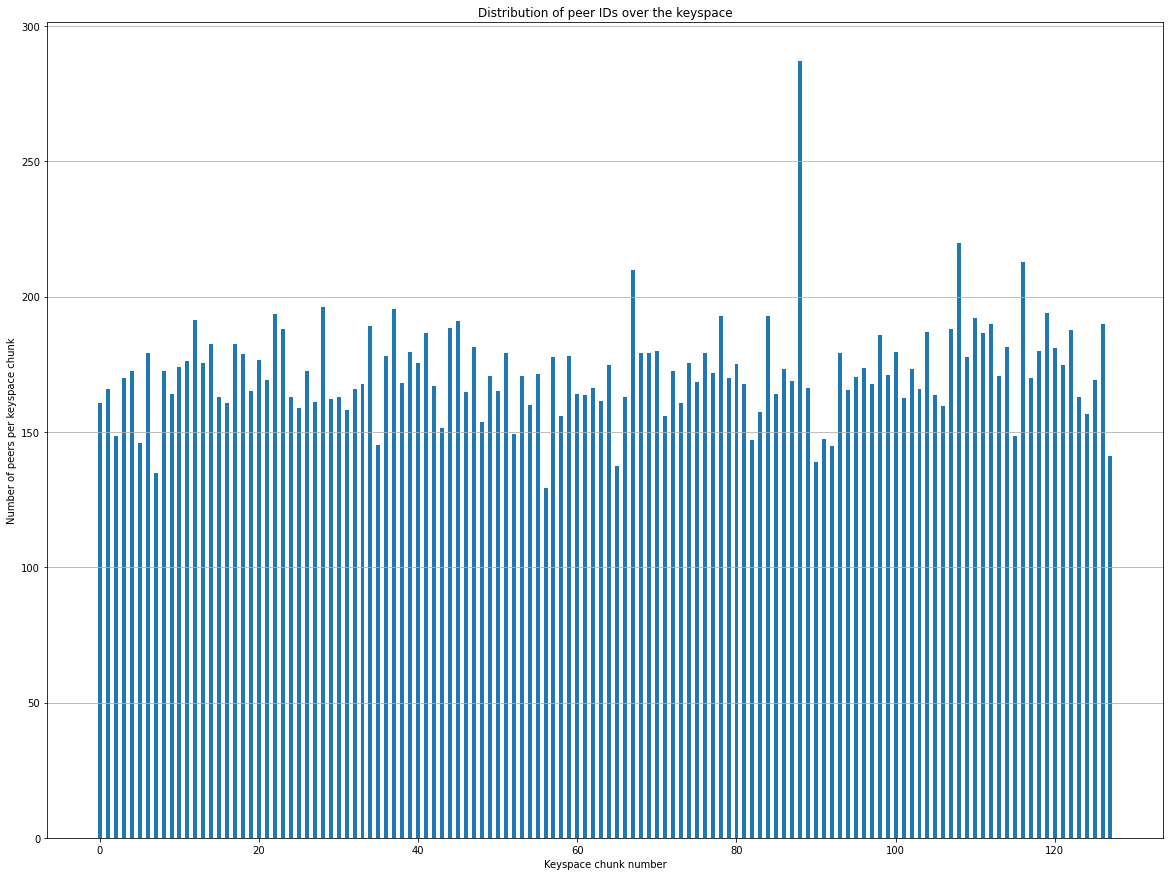

In [33]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.grid(axis='y')

plt.xlabel("Keyspace chunk number")
plt.ylabel("Number of peers per keyspace chunk")
plt.title("Distribution of peer IDs over the keyspace")

plt.bar([x for x in range(len(density))], density, width=0.5)

plt.savefig('plots/online-peerid-distribution.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

In [34]:
density88 = np.average(peerids_distribution_chunk88_data, axis=0)

In [35]:
print("       prefix : occurences\n")
for i in range(len(density88)):
    path="{0:b}".format(i)           # getting binary number
    path='0'*(levels-len(path))+path
    path=int_to_bitstring(88,7)+path
    
    print(path+":", int(density88[i]))

       prefix : occurences

10110000000000: 8
10110000000001: 15
10110000000010: 11
10110000000011: 9
10110000000100: 16
10110000000101: 13
10110000000110: 17
10110000000111: 13
10110000001000: 21
10110000001001: 92
10110000001010: 10
10110000001011: 13
10110000001100: 12
10110000001101: 11
10110000001110: 13
10110000001111: 10


In [36]:
print("Average:            ", round(np.average(density88),2))
print("Standard deviation:  ", round(np.std(density88, ddof=1),2))
print("Max:                ", max(density88))
print("Min:                ", min(density88))

Average:             17.94
Standard deviation:   20.01
Max:                 92.0
Min:                 8.0


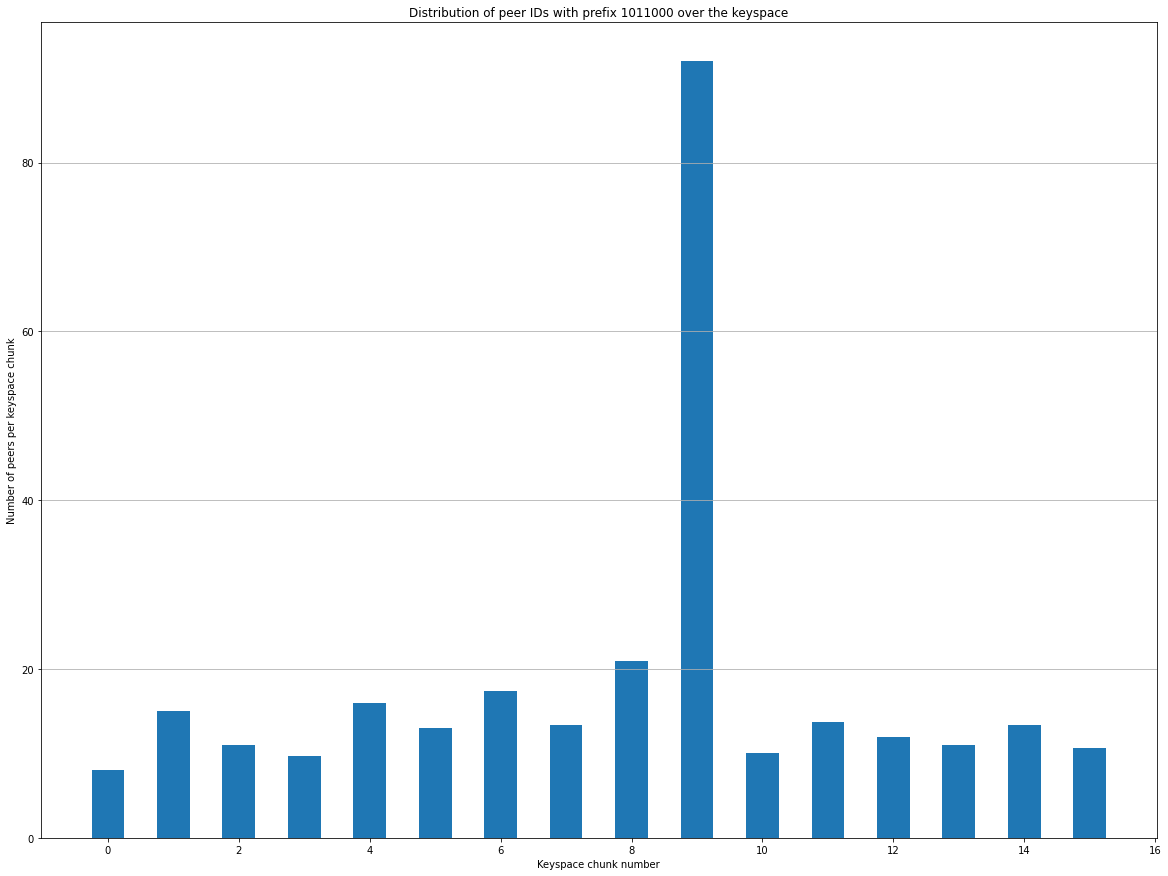

In [37]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.grid(axis='y')

plt.xlabel("Keyspace chunk number")
plt.ylabel("Number of peers per keyspace chunk")
plt.title("Distribution of peer IDs with prefix 1011000 over the keyspace")

plt.bar([x for x in range(len(density88))], density88, width=0.5)

plt.savefig('plots/online-peerid-distribution.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

## PeerID distribution over keyspace (all times)

In [38]:
startTime = time.time()
peerids = [bytes_to_bitstring(multihash_to_kad_id(nebula_peerids[m])) for m in nebula_peerids]
print(time.time() - startTime)

7.974117755889893


In [39]:
startTime = time.time()
t = Trie()
for p in peerids:
    t.add(p)
print(time.time() - startTime)

10.282783269882202


In [40]:
levels=7
density=[0]*2**levels

In [41]:
startTime = time.time()
for i in range(2**levels):
    path="{0:b}".format(i)
    path='0'*(levels-len(path))+path
    
    density[i]=t.find_trie(path).size
print(time.time() - startTime)

0.0007071495056152344


In [42]:
print("Average:            ", round(np.average(density),2))
print("Standard deviation:   ", round(np.std(density, ddof=1),2))
print("Max:                ", max(density))
print("Min:                ", min(density))

Average:             3419.62
Standard deviation:    69.83
Max:                 3632
Min:                 3199


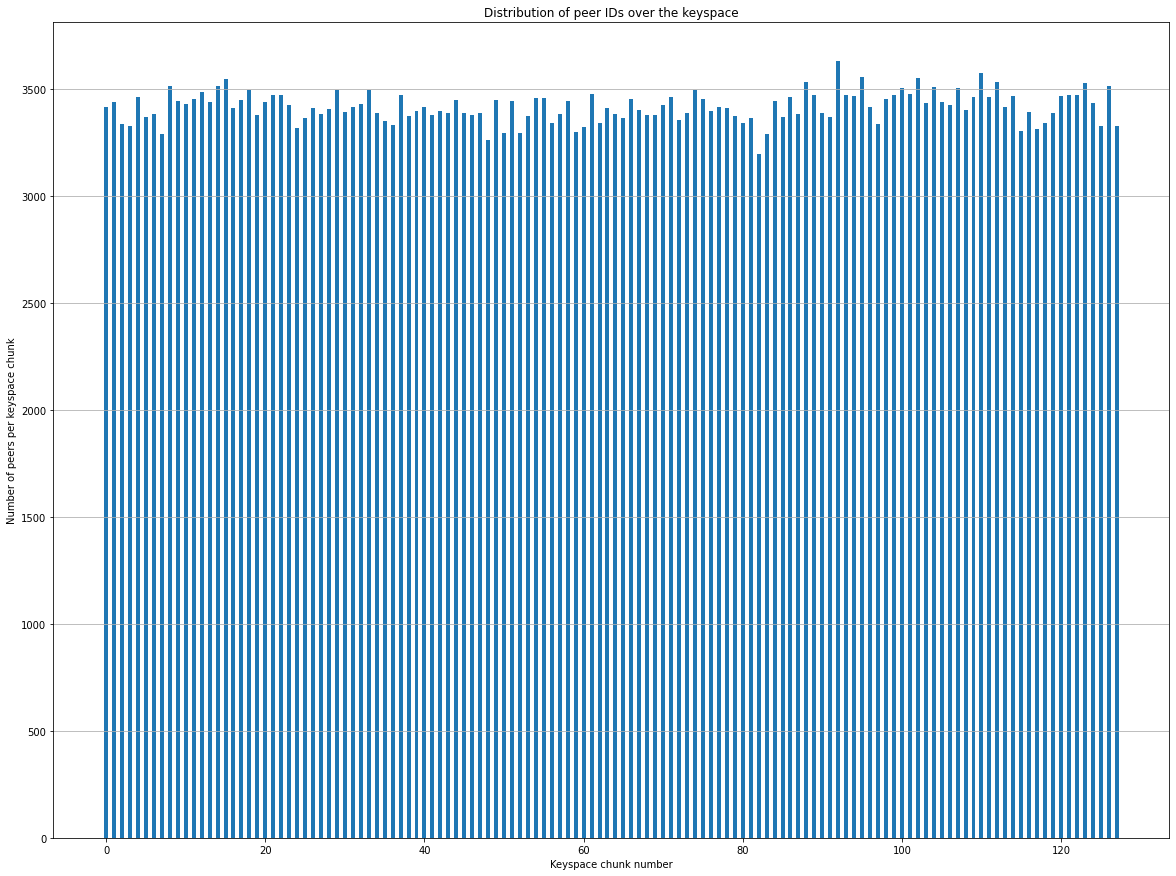

In [43]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.grid(axis='y')

plt.xlabel("Keyspace chunk number")
plt.ylabel("Number of peers per keyspace chunk")
plt.title("Distribution of peer IDs over the keyspace")

plt.bar([x for x in range(len(density))], density, width=0.5)

plt.savefig('plots/peerid-distribution.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

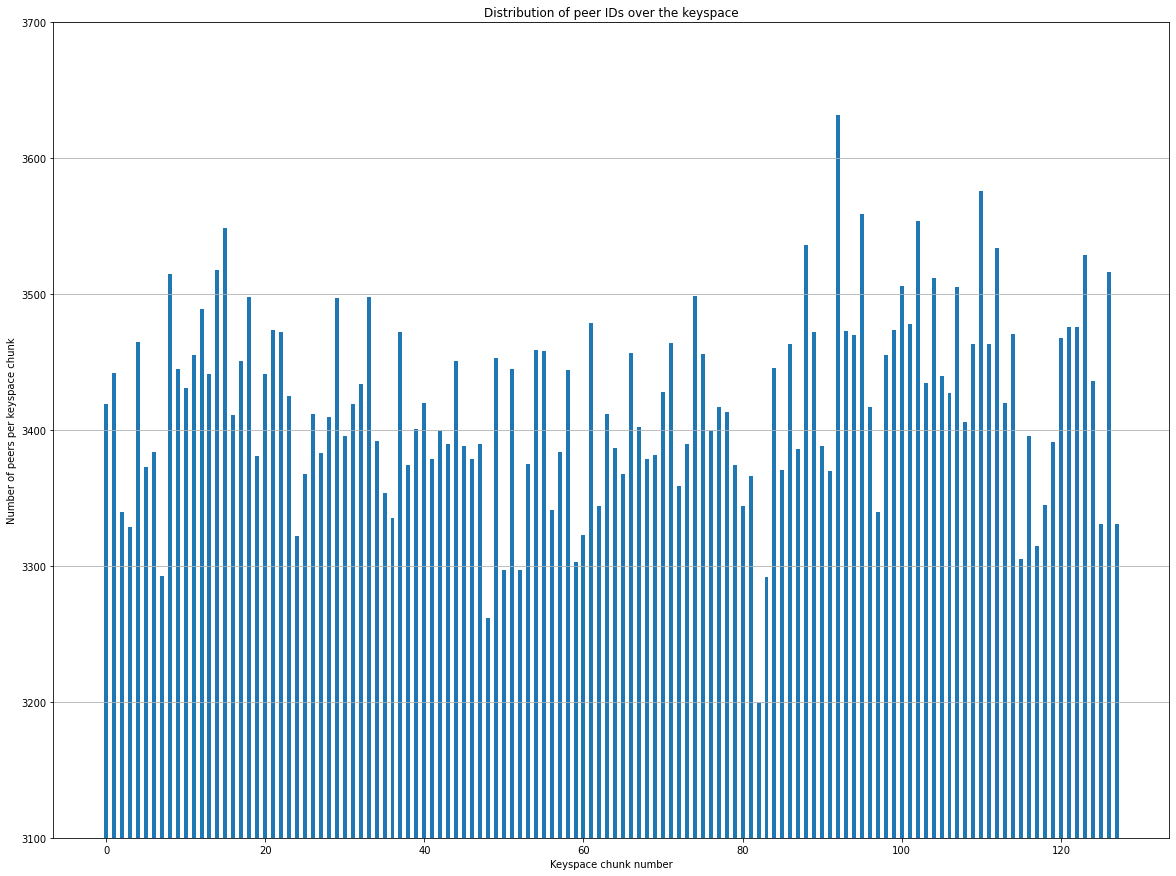

In [44]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.grid(axis='y')

plt.ylim(top=3700, bottom=3100)
plt.xlabel("Keyspace chunk number")
plt.ylabel("Number of peers per keyspace chunk")
plt.title("Distribution of peer IDs over the keyspace")

plt.bar([x for x in range(len(density))], density, width=0.5)

plt.savefig('plots/peerid-distribution.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

In [45]:
levels88_global = 4
density88_global = [0] * 2**levels88_global
for i in range(2**levels88_global):
    path="{0:b}".format(i)           # getting binary number
    path='0'*(levels88_global-len(path))+path # zero padding for constant size bitstring
    path=int_to_bitstring(88,7)+path

    for p in peerids:
        if p[:len(path)] == path:
            density88_global[i]+=1



In [46]:
print("       prefix : occurences\n")
for i in range(len(density88_global)):
    path="{0:b}".format(i)           # getting binary number
    path='0'*(levels-len(path))+path
    path=int_to_bitstring(88,7)+path
    
    print(path+":", int(density88_global[i]))

       prefix : occurences

10110000000000: 228
10110000000001: 207
10110000000010: 226
10110000000011: 223
10110000000100: 226
10110000000101: 196
10110000000110: 215
10110000000111: 212
10110000001000: 206
10110000001001: 269
10110000001010: 241
10110000001011: 219
10110000001100: 239
10110000001101: 191
10110000001110: 228
10110000001111: 210


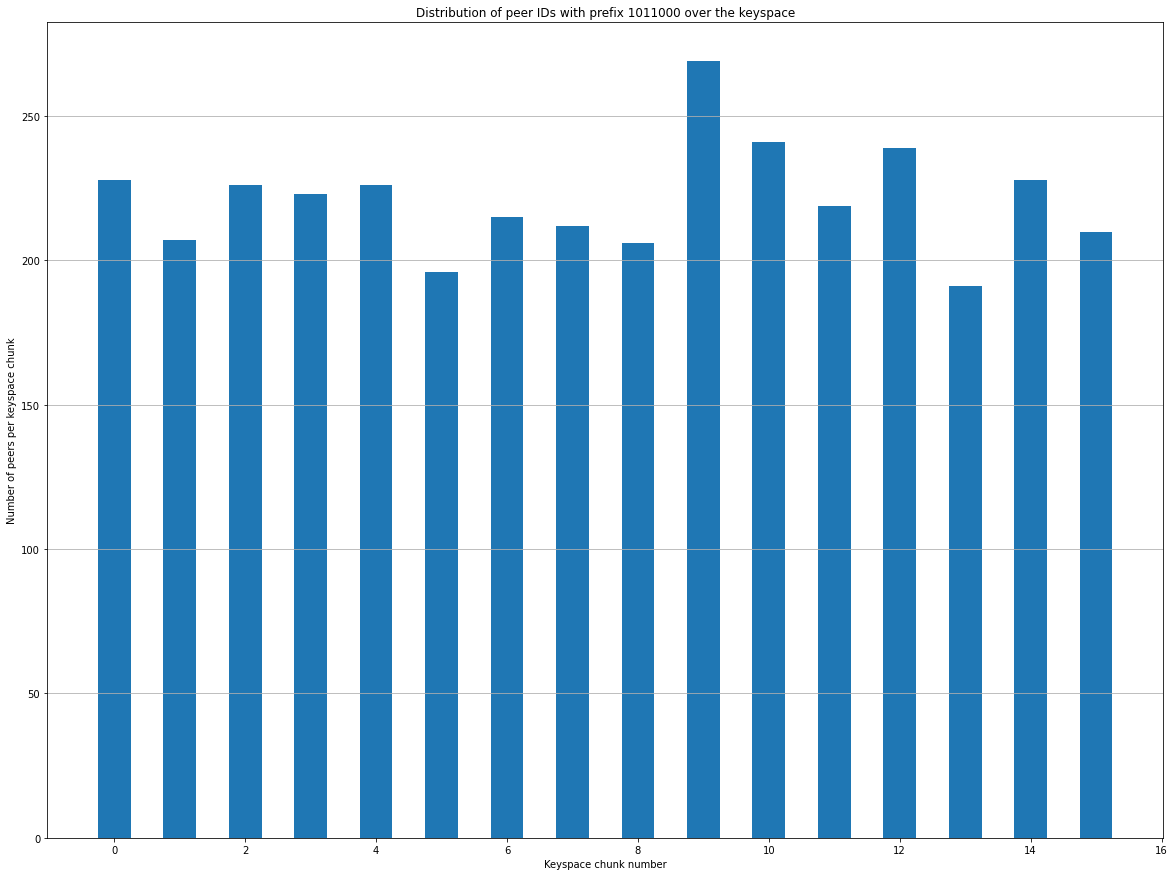

In [47]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.grid(axis='y')

plt.xlabel("Keyspace chunk number")
plt.ylabel("Number of peers per keyspace chunk")
plt.title("Distribution of peer IDs with prefix 1011000 over the keyspace")

plt.bar([x for x in range(len(density88_global))], density88_global, width=0.5)

plt.savefig('plots/online-peerid-distribution.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()